# Validation statistics for multiple products

In [1]:
%matplotlib inline
import os
import sys
import xarray as xr
import numpy as np
import seaborn as sb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import gaussian_kde
from odc.geo.xr import assign_crs
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.simplefilter(action='ignore')

# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from _training import extract_ozflux

## Append pixel values of datasets to OzFlux fluxes

In [2]:
#Comparison datasets
base='/g/data/r78/cb3058/phd/comparison_datasets/'
comparisons = {
    'MODIS_GPP':base+'MODIS_GPP_1km_monthly_2002_2021.nc',
    'GOSIF_GPP':base+'GOSIF_GPP_5km_monthly_2002_2021.nc',
    'OzWALD_GPP':base+'OzWALD_GPP_1km_2003_2023.nc',
    'DIFFUSE_GPP':base+'DIFFUSE_GPP_1km_monthly_2003_2021.nc',
    'FLUXCOM_RS_GPP':base+'GPP_rs.nc',
    'FLUXCOM_RS_NEE':base+'NEE_rs.nc',
    'FLUXCOM_RS_ER':base+'TER_rs.nc',
    'AusEFlux_NEE_v1.2':'/g/data/os22/chad_tmp/AusEFlux/results/AusEFlux/NEE/',
    'AusEFlux_GPP_v1.2':'/g/data/os22/chad_tmp/AusEFlux/results/AusEFlux/GPP/',
    'AusEFlux_ER_v1.2':'/g/data/os22/chad_tmp/AusEFlux/results/AusEFlux/ER/',
    'AusEFlux_ER_v1.2':'/g/data/os22/chad_tmp/AusEFlux/results/AusEFlux/ET/'
}

### Grab the fluxes from the training data

In [3]:
base = '/g/data/os22/chad_tmp/AusEFlux/data/training_data/'
sites = os.listdir(f'{base}')
ec_exclusions=['DalyUncleared', 'RedDirtMelonFarm', 'Loxton']

flux_ts = {}
for site in sites:
    if '.csv' in site:
        if any(exc in site for exc in ec_exclusions): #don't load the excluded sites
            print('skip', site[0:-4])
            continue
        else:
            xx = pd.read_csv(f'{base}{site}',
                             index_col='time', parse_dates=True)
        
        #convert to 1d xarray
        lat, lon = xx[['y_coord']].iloc[0].y_coord, xx[['x_coord']].iloc[0].x_coord
        xx = xx[['GPP_SOLO_EC', 'NEE_SOLO_EC', 'ER_SOLO_EC', 'ET_EC']]  #'x_coord', 'y_coord'
        xx = xx.to_xarray().expand_dims(dim={'latitude':[lat], 'longitude':[lon]})
        xx = xx.squeeze()
        flux_ts[site[0:-4]] = xx

skip DalyUncleared
skip Loxton
skip RedDirtMelonFarm


### Loop through comparsison datasets and extract pixel values

In [4]:
results=[]
for k,v in flux_ts.items():
    print(k)
    lat=v.latitude.values.item()
    lon=v.longitude.values.item()
    time=v.time
    
    for prod,path in comparisons.items():
        #print(prod)
        #deal with AusEFlux datasets
        if 'AusEFlux' in prod:
            files = [f'{path}/{i}' for i in os.listdir(path) if i.endswith(".nc")]
            files.sort()
        
            #combine annual files into one file
            ds = xr.open_mfdataset(files)
            for i in ds.data_vars:
                if "median" in i:
                    var=i
            ds = ds[var]
            
        elif 'FLUXCOM' in prod:
            ds = xr.open_dataset(path)
            ds=ds[path[-9:-6]]
            ds = ds*30
                
        else:
            ds = xr.open_dataarray(path)

        ds = ds.sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice(time[0], time[-1]))
        ds = ds.reindex(time=time, method='nearest', tolerance='1D').compute()#.dropna(dim='time') 
        
        if prod=='MODIS_GPP':
            ds = ds*1000
                
        if prod=='DIFFUSE_GPP':
            ds = ds*30

        v[prod]=ds
    
    df = v.to_dataframe()
    df = df.drop(['spatial_ref'], axis=1)
    df['site'] = k
    results.append(df)
    
#combine all results into one larges df
df = pd.concat(results)
df_with_time= df.copy()
df = df.reset_index(drop=True)

Ridgefield
Boyagin
CowBay
RobsonCreek
CapeTribulation
DryRiver
Warra
Fletcherview
AliceSpringsMulga
WombatStateForest
GreatWesternWoodlands
SamfordEcologicalResearchFacility
SturtPlains
FoggDam
CumberlandPlain
HowardSprings
Collie
Emerald
Litchfield
Yanco
WallabyCreek
Gingin
TiTreeEast
DalyPasture
Tumbarumba
Whroo
RiggsCreek
Otway
SilverPlains
CalperumChowilla
LongreachMitchellGrassRangeland


## Plot

In [5]:
var='GPP'
font=14

### Monthly comparisons

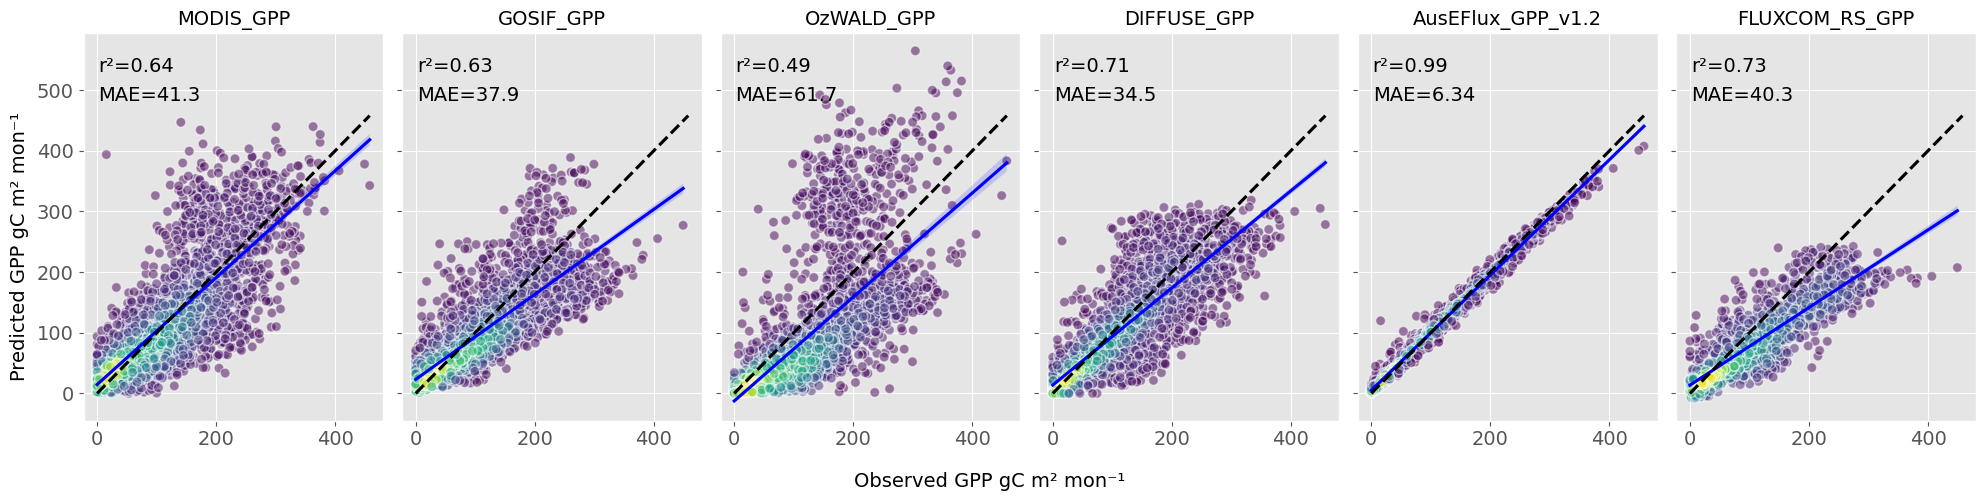

In [6]:
with plt.style.context('ggplot'):
    if var == 'GPP':
        products=['MODIS_GPP', 'GOSIF_GPP','OzWALD_GPP', 'DIFFUSE_GPP', 'AusEFlux_GPP_v1.2', 'FLUXCOM_RS_GPP'] 
        fig,axes = plt.subplots(1,6, figsize=(20,5), sharey=True, sharex=True)
        
    if var=='NEE':
        products=['AusEFlux_NEE_v1.2','FLUXCOM_RS_NEE']
        fig,axes = plt.subplots(1,2, figsize=(8,4), sharey=True, sharex=True)
    
    if var=='ER':
        products=['AusEFlux_ER_v1.2','FLUXCOM_RS_TER']
        fig,axes = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
    
    for prod, ax in zip(products, axes.ravel()):
        
        obs,pred = df[var+'_SOLO_EC'].values, df[prod].values
        mask = ~np.isnan(obs) & ~np.isnan(pred)
        slope, intercept, r_value, p_value, std_err = stats.linregress(obs[mask],pred[mask])
        r2 = r_value**2
        # r2 = r2_score(obs, pred)
        # r2 = sp.stats.pearsonr(obs, pred)
        ac = mean_absolute_error(obs[mask], pred[mask])
        
        xy = np.vstack([obs[mask],pred[mask]])
        z = gaussian_kde(xy)(xy)
    
        sb.scatterplot(data=df, x=var+'_SOLO_EC', y=prod, c=z, s=50, lw=1, alpha=0.5, ax=ax) #
        sb.regplot(data=df, x=var+'_SOLO_EC',y=prod, scatter=False, color='blue', ax=ax)
        sb.regplot(data=df, x=var+'_SOLO_EC',y=var+'_SOLO_EC', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
        ax.set_title(prod, fontsize=font)
        ax.set_xlabel('')
        ax.set_ylabel('')
        # ax.set_aspect(1.5)
        ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
                transform=ax.transAxes, fontsize=font)
        ax.text(.05, .825, 'MAE={:.3g}'.format(np.mean(ac)),
                transform=ax.transAxes, fontsize=font)
        ax.tick_params(axis='x', labelsize=font)
        ax.tick_params(axis='y', labelsize=font)
    
    fig.supylabel('Predicted '+var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹', x=0.01, y=0.5, fontsize=font)
    fig.supxlabel('Observed '+var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹', fontsize=font);
    # plt.tight_layout()
    plt.tight_layout(pad=1.0)
    fig.savefig('/g/data/os22/chad_tmp/AusEFlux/results/figs/cross_val_intercomparison_native_'+var+'.png',
               bbox_inches='tight', dpi=300)

### Annual comparisons

Coloured by biome

In [7]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

gdf_ts = gpd.GeoDataFrame(
    df_with_time, geometry=gpd.points_from_xy(df_with_time.longitude, df_with_time.latitude))

gdf_ts.crs = gdf.crs

gdf_ts = gdf_ts.sjoin(gdf, how="left")

gdf_ts.loc[gdf_ts['site'] == 'CapeTribulation', ['bioclimatic_regions']] = 1.0
gdf_ts.loc[gdf_ts['site'] == 'CowBay', ['bioclimatic_regions']] = 1.0

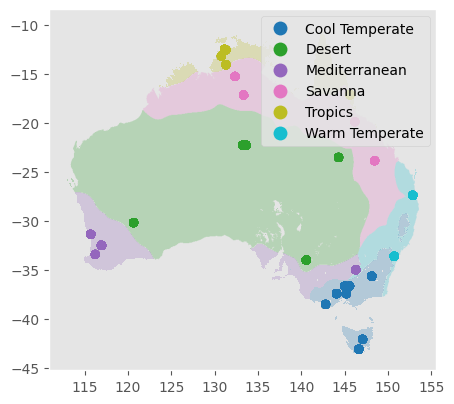

In [8]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    gdf.plot(column='region_name', ax=ax, alpha=0.25)
    gdf_ts.plot(ax=ax, column='region_name', legend=True)
    ax.grid(None)

In [9]:
#resample to mean over the year
df= gdf_ts.drop(['geometry', 'region_name'],axis=1).groupby('site').resample('Y').mean()
### Reclassify region names for nice plotting
df.loc[df['bioclimatic_regions'] == 1.0, ['region']] = 'Tropics'
df.loc[df['bioclimatic_regions'] == 2.0, ['region']] = 'Savanna'
df.loc[df['bioclimatic_regions'] == 3.0, ['region']] = 'Warm Temperate'
df.loc[df['bioclimatic_regions'] == 4.0, ['region']] = 'Cool Temperate'
df.loc[df['bioclimatic_regions'] == 5.0, ['region']] = 'Mediterranean'
df.loc[df['bioclimatic_regions'] == 6.0, ['region']] = 'Desert'

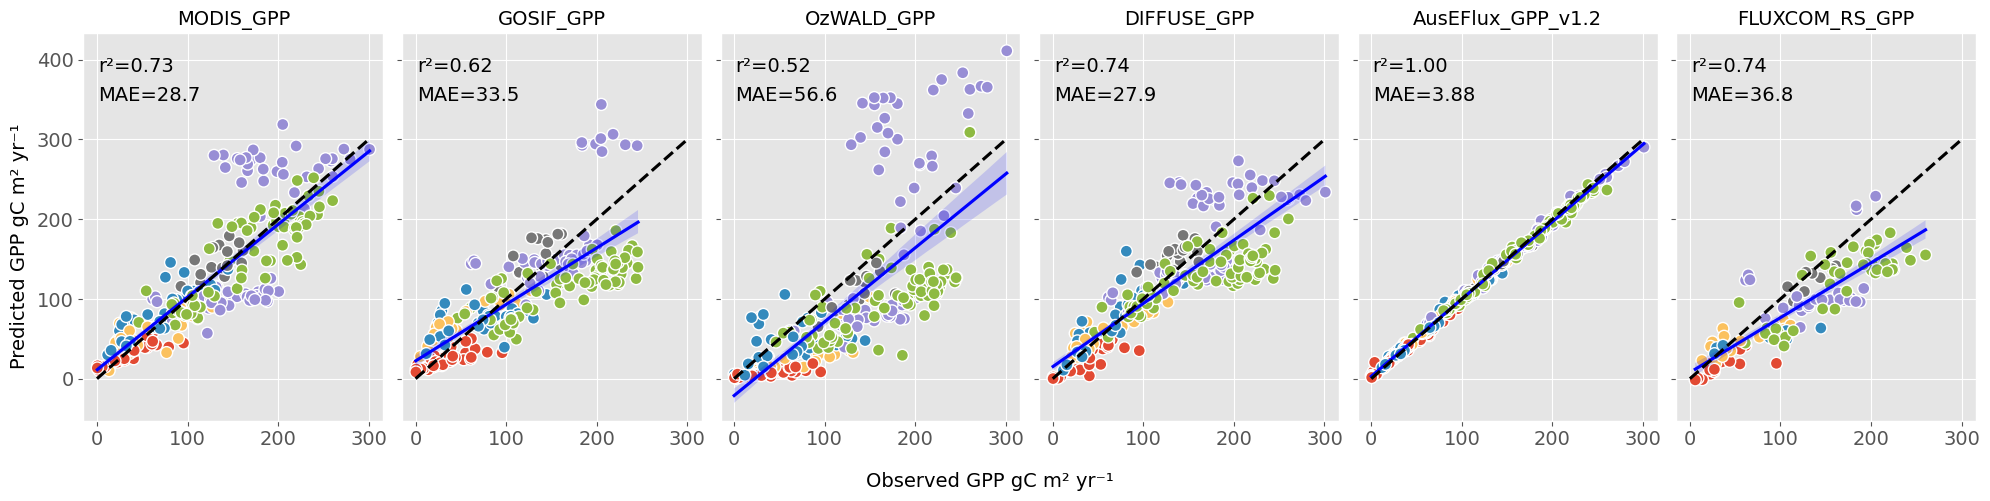

In [10]:
with plt.style.context('ggplot'):
    if var == 'GPP':
        products=['MODIS_GPP', 'GOSIF_GPP','OzWALD_GPP', 'DIFFUSE_GPP', 'AusEFlux_GPP_v1.2', 'FLUXCOM_RS_GPP'] 
        fig,axes = plt.subplots(1,6, figsize=(20,5), sharey=True, sharex=True)
        
    if var=='NEE':
        products=['AusEFlux_NEE_v1.2','FLUXCOM_RS_NEE']
        fig,axes = plt.subplots(1,2, figsize=(8,4), sharey=True, sharex=True)
    
    if var=='ER':
        products=['AusEFlux_ER_v1.2','FLUXCOM_RS_TER']
        fig,axes = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
    
    for prod, ax in zip(products, axes.ravel()):
        
        obs,pred = df[var+'_SOLO_EC'].values, df[prod].values
        mask = ~np.isnan(obs) & ~np.isnan(pred)
        slope, intercept, r_value, p_value, std_err = stats.linregress(obs[mask],pred[mask])
        r2 = r_value**2
        # r2 = r2_score(obs, pred)
        # r2 = sp.stats.pearsonr(obs, pred)
        ac = mean_absolute_error(obs[mask], pred[mask])
        
        sb.scatterplot(data=df, x=var+'_SOLO_EC', y=prod, hue='region', s=75, lw=1, ax=ax, legend=False) #
        sb.regplot(data=df, x=var+'_SOLO_EC',y=prod, scatter=False, color='blue', ax=ax)
        sb.regplot(data=df, x=var+'_SOLO_EC',y=var+'_SOLO_EC', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
        ax.set_title(prod, fontsize=font)
        ax.set_xlabel('')
        ax.set_ylabel('')
        # ax.set_aspect(1.5)
        ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
                transform=ax.transAxes, fontsize=font)
        ax.text(.05, .825, 'MAE={:.3g}'.format(np.mean(ac)),
                transform=ax.transAxes, fontsize=font)
        ax.tick_params(axis='x', labelsize=font)
        ax.tick_params(axis='y', labelsize=font)
    
    fig.supylabel('Predicted '+var+' gC m\N{SUPERSCRIPT TWO} yr⁻¹', x=0.01, y=0.5, fontsize=font)
    fig.supxlabel('Observed '+var+' gC m\N{SUPERSCRIPT TWO} yr⁻¹', fontsize=font);
    # plt.tight_layout()
    plt.tight_layout(pad=1.0)
    fig.savefig('/g/data/os22/chad_tmp/AusEFlux/results/figs/cross_val_intercomparison_native_annual_biome_'+var+'.png',
               bbox_inches='tight', dpi=300)

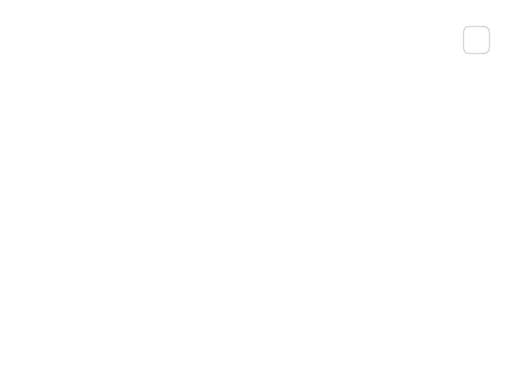

In [11]:
# get handles and labels for reuse
label_params = ax.get_legend_handles_labels() 

figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc='best', fontsize=24, markerscale=4, ncol=1)
figl.savefig('/g/data/os22/chad_tmp/AusEFlux/results/figs/legend_biomes.png',
            bbox_inches='tight', dpi=300)